In [74]:
%pip install pandas seaborn matplotlib xgboost 
%pip install scikit-learn
# Tell Jupyter to automatically reload modules before executing code (avoids having to manually reload every time I edit helper functions)
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Air Quality and Health Risk Forecaster

## Introduction

This project is in response to the following optimization problem:

"Urban air pollution and fluctuating weather conditions have a direct impact on public health, especially in major cities where population density and pollution levels are high. Your task is to develop a predictive model that can assess the health risk of residents based on air quality (PM2.5, NO2, CO2) and weather conditions (temperature, humidity, wind, etc.) in various U.S. cities.

The goals and requirements of this study are as follows:

1.	Create a predictive model that accurately forecasts air quality levels based on weather conditions and pollution metrics (PM2.5, NO2, CO2).

2.	Develop a highly efficient predictive model that assesses health risks based on urban air quality, weather data, and other relevant factors.

You will implement the chosen models for both urban air quality forecasting and health risk prediction and evaluate their performance using appropriate metrics such as RMSE, MAPE, and trend analysis. Ensure that the models accurately capture the relationships between weather conditions, pollution metrics, and health outcomes and assess their effectiveness across different time periods and urban areas."

In this notebook, I will build, train, and optimize a machine learning solution for this problem.

## Determining the Dependent Variables

The first step is to select features to serve as the dependent variables. Because the request is for a model that can forecast both air quality and health risk, two dependent variables are needed. To determine which features are appropriate for this, inspect the features that are in the dataset:

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Necessary for handling the import of the helper methods
import sys
sys.path.append("..")
from model_methods.implement_initial_model import implement_initial_model
from model_methods.optimize_model import optimize_model
from evaluation_methods.calculate_feature_importance import calculate_feature_importance
from sklearn.model_selection import train_test_split

PATH = "../data/raw/DQN1 Dataset.csv"
df = pd.read_csv(PATH)
print(df.columns)

Index(['datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'pm2.5', 'no2', 'co2', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed',
       'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunriseEpoch', 'sunsetEpoch',
       'moonphase', 'tempRange', 'heatIndex', 'severityScore', 'month',
       'dayOfWeek', 'isWeekend', 'healthRiskScore'],
      dtype='object')


The dataset contains a healthRiskScore feature that can used to measure health risk. However, there is no singular feature for measuring air quality. There are, however, three pollutant features: pm2.5, no2, and co2. Since the problem statement references these in connection with air quality, it makes sense to apply some feature engineering to create a composite "air quality" feature from the individual pollutant values.

For my initial model implementation, I will take a simple average of the pollutant values and analyze how that performs.

In [76]:
# Measure air quality by taking the average of pm2.5, no2, and co2.
df["airQuality"] = df[["pm2.5", "no2", "co2"]].mean(axis=1)

## Exploring Feature Types

Next, I want to examine the datatype of each feature in the dataset.

In [77]:
print(df.dtypes)

datetimeEpoch        int64
tempmax            float64
tempmin            float64
temp               float64
feelslikemax       float64
feelslikemin       float64
feelslike          float64
pm2.5              float64
no2                float64
co2                float64
dew                float64
humidity           float64
precip             float64
precipprob         float64
precipcover        float64
windgust           float64
windspeed          float64
winddir            float64
pressure           float64
cloudcover         float64
visibility         float64
solarradiation     float64
solarenergy        float64
uvindex            float64
severerisk         float64
sunriseEpoch         int64
sunsetEpoch          int64
moonphase          float64
tempRange          float64
heatIndex          float64
severityScore      float64
month                int64
dayOfWeek            int64
isWeekend             bool
healthRiskScore    float64
airQuality         float64
dtype: object


All of the features are numeric except for isWeekend, which is boolean. I am going to use XGBoost for this project, and newer version of XGBoost handle categorical variables well, so I don't necessarily *have* to one-hot encode this feature. However, doing so will give me the flexibility to experiment with other models later if I choose to. Also, because isWeekend is boolean, there are only two categories, so adding sparsity is less of a concern than it might be if there were more categories. Therefore, I will go ahead and one-hot encode this feature.

In [78]:
# This handles isWeekend by converting it to one-hot encoding. drop_first = True
# is needed because we don't need a column for both True and False.
df_numeric = pd.get_dummies(df, drop_first = True) 

## Choice of Model

For this task, I will use XGBoost. I believe that for this particular problem, XGBoost’s speed and accuracy outweigh any concerns around its complexity or interpretability.

The problem description above specifies two components of this optimization problem: 

1. Forecast air quality based on weather conditions and pollution metrics. 
2. Assess health risks based on urban air quality, weather data, and other relevant factors.

The goal is to develop a model that optimizes the prediction of both air quality and health risk scores using the provided dataset. These are continuous features, so this is a regression problem, not a classification problem. XGBoost is designed to handle tasks that require continuous numeric prediction, making it ideally suited for regression problems of this nature [1]. 

Additionally, the problem statement mentions evaluating the model's performance based on metrics such as RMSE and MAPE. XGBoost can quickly provide these and many other metrics to assess its performance, meaning it is well-equipped to provide a robust analysis of the algorithm’s performance. Furthermore, XGBoost provides an extensive set of hyperparameters that can be tuned to improve the results [2]. Consequently, it will offer significant room for experimentation to optimize performance. Finally, the problem statement requests a “highly efficient predictive model”. XGBoost utilizes parallel processing to analyze large datasets quickly [3], enabling it to handle large urban datasets more efficiently than traditional sequential boosting methods. Thus, XGBoost is a highly efficient predictive model.

## Implementation of Initial Models

In [79]:
# Dependent variables for each model
AIR_QUALITY_Y = "airQuality"
HEALTH_RISK_Y = "healthRiskScore"

# Model 1: Build, train, and run the baseline Air Forecaster model.
air_model, air_rmse, air_mape = implement_initial_model(df_numeric, AIR_QUALITY_Y)

# Model 2: Build, train, and run the baseline Health Risk Score model.
health_model, health_rmse, health_mape = implement_initial_model(df_numeric, HEALTH_RISK_Y)

## Evaluation of Initial Models

Since they are specifically mentioned in the problem statement, the two evaluation metrics I’m using are Root Mean Squared Error (“RMSE”) and Mean Absolute Percentage Error (“MAPE”). These two metrics provide two different but equally valuable ways to visualize my model’s errors. RMSE displays errors in the same units as the dependent variable, which makes it easy to visualize how far off the model is [4]. In contrast, MAPE displays errors as a percentage value, making comparison easier [4]. That is particularly useful here, since I will have two models: one to forecast air quality and one to predict health risk. 

The downside to RMSE and MAPE is that both are sensitive to outliers. RMSE significantly penalizes large errors, which can be helpful, but can also result in those errors dominating the metric [4]. MAPE tends to punish negative outliers more than positive ones [4]. This often results in forecasts that are too low [5]. I will need to keep these sensitivities in mind as I implement and optimize my model.

In [80]:
# Print the results for both baseline models.
print(f"Baseline Air Quality Forecaster RMSE: {air_rmse}")
print(f"Baseline Air Quality Forecaster MAPE: {air_mape}")
print(f"Baseline Health Risk Forecaster RMSE: {health_rmse}")
print(f"Baseline Health Risk Forecaster MAPE: {health_mape}")

Baseline Air Quality Forecaster RMSE: 0.8250745403879898
Baseline Air Quality Forecaster MAPE: 0.0035825125937907452
Baseline Health Risk Forecaster RMSE: 0.12317775490090055
Baseline Health Risk Forecaster MAPE: 0.009195693279249812


The low MAPE scores for both models are promising, indicating that the baseline model is already performing well. However, the RMSE for the air quality model is significantly higher than the RMSE for the health risk model, whereas the MAPE for the air quality model is lower. The higher RMSE may be due to the raw values for the pollutants that were averaged to compute air quality being much larger than the raw values for healthRiskScore. When creating my air quality feature, I simply averaged the pollutant values without exploring those features in any depth. I need to explore these features in more detail to 1) better understand the performance of my initial models and 2) determine whether taking a simple average of the pollutant values is a valid way to calculate air quality.

## Exploratory Data Analysis

The below code prints the basic descriptive statistics and produces histograms showing the distributions of the respective pollutant variables.

--- Descriptive Statistics ---
             pm2.5          no2          co2
count  1000.000000  1000.000000  1000.000000
mean     32.737480    30.311160   446.955880
std       6.312905     4.801367    25.910237
min      11.740000    12.400000   381.200000
25%      28.355000    27.030000   427.755000
50%      32.695000    30.130000   447.145000
75%      37.282500    33.740000   465.225000
max      52.380000    42.660000   523.640000
Distributions saved.


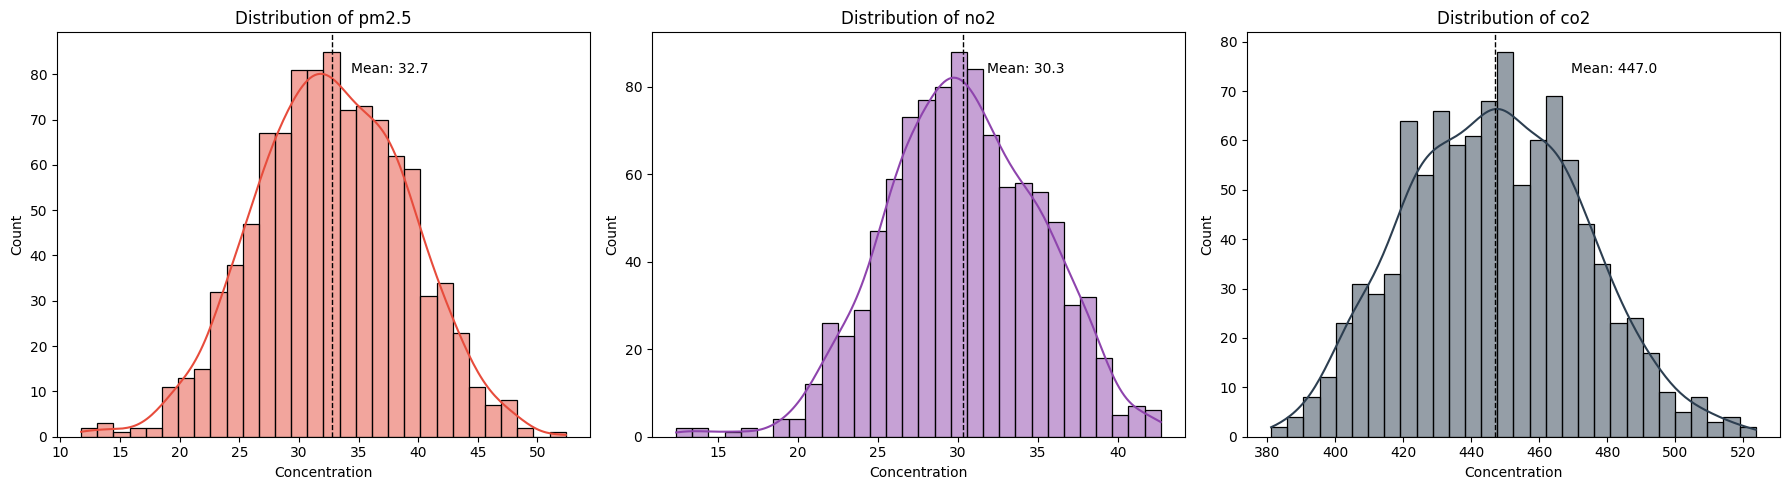

In [81]:
pollutants = ["pm2.5", "no2", "co2"]

print("--- Descriptive Statistics ---")
print(df_numeric[pollutants].describe())

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

colors = ["#e74c3c", "#8e44ad", "#2c3e50"] 

# Plot a histogram showing the distribution of each pollutant
for i, var in enumerate(pollutants):
    sns.histplot(df_numeric[var], kde = True, ax = axes[i], color = colors[i], bins = 30)
    
    # Calculate mean for annotation
    mean_val = df_numeric[var].mean()

    axes[i].axvline(mean_val, color = "k", linestyle = "--", linewidth = 1)
    axes[i].text(mean_val * 1.05, axes[i].get_ylim()[1] * 0.9, f"Mean: {mean_val:.1f}")
    
    axes[i].set_title(f"Distribution of {var}")
    axes[i].set_xlabel("Concentration")

plt.tight_layout()
plt.savefig("../visualizations/pollutant_dist.png")
print("Distributions saved.")


A notable trend evident in these statistics is that co2 values are much larger, in absolute terms, than pm2.5 and no2 values. The pm2.5 and no2 features have similar means (32.7 and 30.3, respectively), but co2’s mean is 447.0. This is about fourteen times larger than the means of the other two pollutant features. Moreover, the standard deviation of the co2 feature (~25.9) is nearly as large as the mean of the other pollutants. 

This also likely explains why the RMSE was much higher for air quality than for health risk. The descriptive statistics for healthRiskScore confirm this.

In [82]:
print("--- healthRiskScore Descriptive Statistics ---")
print(df_numeric["healthRiskScore"].describe())

--- healthRiskScore Descriptive Statistics ---
count    1000.000000
mean        9.729120
std         0.679734
min         8.490000
25%         9.200000
50%         9.550000
75%        10.242500
max        11.490000
Name: healthRiskScore, dtype: float64


The mean of the healthRiskScore is only ~9.7, significantly less than the mean of each pollutant feature.

This scaling issue with my pollutant features indicates my initial approach of calculating air quality by simply averaging these three features was not appropriate. The large co2 values dominated the average, creating a misleading measure of air quality that weakened the model’s analysis. Any approach that treats these features as mathematically equal will be mathematically biased toward co2. 

A better approach might be to normalize the values of these features before taking the average. However, before I do that, I want to take a brief look at the correlation among these features.

In [83]:
# Print the correlation matrix of the pollutants
print("--- Correlation Matrix ---")
print(df_numeric[pollutants].corr())

--- Correlation Matrix ---
          pm2.5       no2       co2
pm2.5  1.000000  0.544206  0.550005
no2    0.544206  1.000000  0.523929
co2    0.550005  0.523929  1.000000


The correlation matrix indicates a consistent, moderate positive correlation among all three pollutant features. This correlation suggests that the pollutants may originate from a shared source, causing them to rise and fall together, and that they are likely manifestations of a single underlying factor.

This justifies my decision to combine them into a single feature by taking the normalized average, as combining features is a common technique for addressing multicollinearity [6]. This is particularly true given the correlation levels present here. If the pollutants were correlated with one another at a much higher level (say, greater than 0.9), I could just use one of them and drop the other two. There would be no need to combine them. On the other hand, if there were no correlation at all, it would not make sense to average them, as doing so could lead to information loss. However, correlation levels of ~0.5 represent a sweet spot. They indicate that each pollutant feature is conveying enough unique information to militate against dropping it, but not so much that something important will be lost if they are combined into a composite air quality feature. Thus, creating a composite feature from the normalized averages of these pollutants makes sense.

## Creating an Optimized Air Quality Feature

Below, I create a better air quality feature by taking the normalized average of the pollutant features.

In [84]:
scaler = MinMaxScaler()
# Create normalized verions of the pollutant features
df_numeric[["pm2.5_norm", "no2_norm", "co2_norm"]] = scaler.fit_transform(
    df_numeric[["pm2.5", "no2", "co2"]]
)
# Take the average of the normalized pollutant features
df_numeric["airQualityOptimized"] = df_numeric[["pm2.5_norm", "no2_norm", "co2_norm"]].mean(axis = 1)
# Confirm normalization was successful
print(df_numeric["airQualityOptimized"].describe())

count    1000.000000
mean        0.523406
std         0.137658
min         0.067210
25%         0.425646
50%         0.521425
75%         0.610331
max         0.885590
Name: airQualityOptimized, dtype: float64


Now air quality is measured on a 0-to-1 scale with a mean of ~0.52. No single pollutant is dominating the measurement.

Since the original air quality feature is no longer needed, drop it from the dataframe.

In [85]:
# Drop the first composite air quality feature I initially created
df_numeric = df_numeric.drop("airQuality", axis = 1)
# Confirm original air quality column was dropped successfully
print(df_numeric.columns)


Index(['datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'pm2.5', 'no2', 'co2', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed',
       'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunriseEpoch', 'sunsetEpoch',
       'moonphase', 'tempRange', 'heatIndex', 'severityScore', 'month',
       'dayOfWeek', 'isWeekend', 'healthRiskScore', 'pm2.5_norm', 'no2_norm',
       'co2_norm', 'airQualityOptimized'],
      dtype='object')


## Addressing Data Leakage

Another critical issue that likely affected my initial models is data leakage. After creating the initial composite air quality feature, I did not drop the individual pollutant features from the dataframe. This means that there is a high probability that data leakage affected the performance of my initial air quality model. An RMSE of ~0.82 on a feature that has a mean value in the low triple digits is actually quite low. The MAPE for the air quality model was also three times lower than the MAPE of the health risk model. There is a significant chance that these metrics are artificially low because of data leakage. XGBoost is a sophisticated model. It likely learned that it could simply predict air quality by averaging the individual pollutants.

Initial Air Quality Feature Importance Chart Saved


<Figure size 1000x600 with 0 Axes>

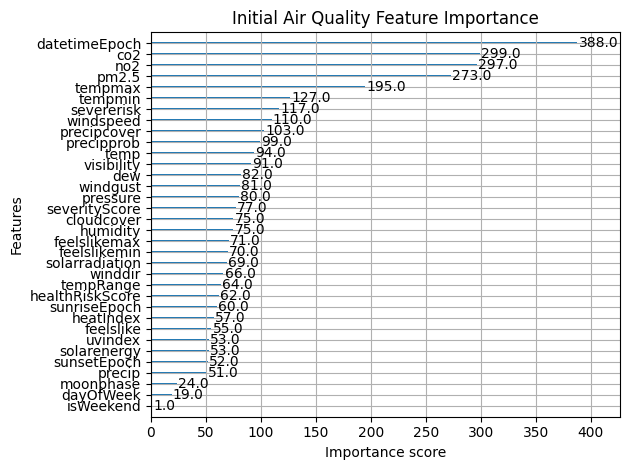

In [86]:
calculate_feature_importance(air_model, "Initial Air Quality")

The feature importance scores confirm this. 3 of the top 4 most important features are the individual pollutants. To address this data leakage issue, I will drop the individual pollutant features (and the normalized versions I just created) from the dataframe.

In [87]:
# To prevent data leakage, drop the columns used to create the composite air
# quality feature
cols_to_drop = ["pm2.5", "no2", "co2", "pm2.5_norm", "no2_norm", "co2_norm"]
df_numeric = df_numeric.drop(columns = cols_to_drop)

## Model Optimization

I'm now ready to move to model optimization. XGBoost offers a wide array of options for hyperparameter tuning, but this can be a double-edged sword. It offers susbstantial flexibility, but also means that some difficult choices have to be made. I will choose a sampling of ensemble, regularization, and optimization techniques and run a grid search to analyze all possible combinations of them.

**Optimization Technique - Apply Shrinkage**

The first optimization technique I chose was to use the learning_rate parameter to apply “shrinkage” to the size of the steps my algorithm takes toward the minimum. I decided to do this because a common risk of gradient boosting machine learning algorithms is overshooting the minimum [7], which results in the algorithm failing to discover the optimal model. The likelihood of falling victim to this pitfall can be reduced by shrinking the algorithm’s step size, which can be achieved by modifying the learning_rate parameter [7]. The opposite problem is also a concern: if the step size is too small, the algorithm may get stuck at a local minimum [7], which appears to be the optimal model but is not. Thus, it is also important not to reduce the step size too drastically. This is where a grid search excels, and where my two primary optimization techniques complement each other. Using a grid search, I experimented with multiple learning rates to determine which one performed best.

**Ensemble Techniques Boosting and Bagging (Subsampling)**

XGBoost contains a built-in ensemble learning technique via its use of multiple decision trees. The model’s performance can be affected by the number of trees it uses. Too few trees can lead to underfitting, but too many trees can lead to overfitting (in addition to slower training and prediction, which violates the problem statement's requirement for a highly efficient model) [8]. Thus, it seemed logical to experiment with the number of trees added to the model as my first ensemble learning technique. To accomplish this, I added a couple of different values for the n_estimators hyperparameter to my grid search.

For my second ensemble learning technique, I used “bagging” by adding the subsample hyperparameter to my Grid Search. I chose this technique because it helps accomplish three different goals. First, the problem statement emphasizes that the model should be accurate. Bagging reduces overfitting to the training data by training each tree on a subset of the data rather than the whole dataset, thereby improving the model’s accuracy on the test data [9]. Second, by training the various trees on different subsets of the data, bagging often improves the model’s generalization [9]. Finally, the problem statement specifies that the model must be efficient. Since the whole dataset is not being used for each tree, bagging speeds up the model’s training process.

**Regularization Techniques - L1 and L2 Regularizations**

For my regularization techniques, I chose to apply L1 (Lasso) Regularization (via the reg_alpha hyperparameter) and L2 (Ridge) Regularization (via the reg_lambda hyperparameter). I chose these because they are two of the most common methods for preventing overfitting in multiple regression models [10]. Additionally, they offer contrasting approaches to regularization. 

L1 Regularization encourages feature sparsity by applying a penalty that drives some coefficients to zero [11]. This further helps my model satisfy the problem statement's efficiency requirements by placing more emphasis on the most salient features while deemphasizing features that are irrelevant or redundant.

In contrast, L2 Regularization tends to reduce feature coefficients more uniformly [10]. This is particularly effective for handling datasets where independent variables are highly correlated [12]. Because the dataset comprises numerous weather-related features, it is likely that some of these features are highly correlated with each other. Thus, Ridge Regression is a suitable fit for the dataset, helping to ensure the model accurately captures the relationships among the different features as requested in the problem statement.

I also added a third regularization technique via max_depth. A common source of overfitting in tree models is overly deep/complex trees [13]. By using max_depth to cap the depth of the model's trees, I can mitigate this tendency and further regularize the model to make it more generalizable.



In [88]:
# Parameters to test during the grid search
PARAM_GRID = {
    # ENSEMBLE TECHNIQUE 1: BOOSTING (n_estimators controls the number of boosting
    # rounds)
    "n_estimators": [100, 200],
    # ENSEMBLE TECHNIQUE 2: BAGGING (SUBSAMPLING) (using < 1.0 means the model is
    # using Bagging/Stochastic Boosting)
    "subsample": [0.8, 0.9],
    # REGULARIZATION TECHNIQUE 1: L1 (LASSO) REGULARIZATION   
    "reg_alpha": [0.1, 0.5],     
    # REGULARIZATION TECHNIQUE 2: L2 (RIDGE) REGULARIZATION   
    "reg_lambda": [0.1, 0.5],
    # OPTIMIZATION TECHNIQUE: SHRINKAGE VIA LEARNING RATE (slow down learning
    # rate to avoid overshooting the optimal model)            
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

### Model Optimization - Air Quality

Note that below, I also drop healthRiskScore from the air quality model because it seems circular to predict air quality from health risk.

In [89]:
print("\n=== OPTIMIZING AIR QUALITY MODEL ===")
    
# It doesn't really make sense to predict air quality from health risk.
# Generally, health risk is predicted from air quality, not the other way 
# around. So drop the healthRiskScore feature
X_air = df_numeric.drop(columns=["airQualityOptimized", "healthRiskScore"]) 
y_air = df_numeric["airQualityOptimized"]

# Split (use the same random_state for fair comparison)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_air, y_air, test_size = 0.2, random_state = 42
)

# Run a grid search on the model using the various parameters specified above to determine the most optimal model
opt_air, opt_air_rmse, opt_air_mape, opt_air_params = optimize_model(
    X_train_a, y_train_a, X_test_a, y_test_a, PARAM_GRID
)

print(f"Optimized Air Quality RMSE: {opt_air_rmse}")
print(f"Optimized Air Quality MAPE: {opt_air_mape}")


=== OPTIMIZING AIR QUALITY MODEL ===
Starting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Optimized Air Quality RMSE: 0.06603924666446008
Optimized Air Quality MAPE: 0.1071989679406081


### Model Optimization - Health Risk

I do, however, use air quality as a predictor of health risk.

In [90]:
print("\n=== OPTIMIZING HEALTH RISK MODEL ===")
    
# It does make sense to use air quality as a predictor for health risk, so 
# while dropping healthRiskScore from the Air Quality Model above made sense,
# it does not make sense to drop the pollutant features or the custom
# airQuality_optimized feature I created above from my Health Risk Model
X_health = df_numeric.drop(columns=["healthRiskScore"])
y_health = df_numeric["healthRiskScore"]

# Split (use the same random_state for fair comparison)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_health, y_health, test_size = 0.2, random_state = 42
)

# Run a grid search on the model using the various parameters specified above 
# to determine the most optimal model
opt_health, opt_health_rmse, opt_health_mape, opt_health_params = optimize_model(
    X_train_h, y_train_h, X_test_h, y_test_h, PARAM_GRID
)

print(f"Optimized Health Risk RMSE: {opt_health_rmse}")
print(f"Optimized Health Risk MAPE: {opt_health_mape}")


=== OPTIMIZING HEALTH RISK MODEL ===
Starting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.8}
Optimized Health Risk RMSE: 0.11241926436051096
Optimized Health Risk MAPE: 0.008804837814657327


## Sources

[1] Brownlee, J. (2021). XGBoost for Regression. Machine Learning Mastery. https://machinelearningmastery.com/xgboost-for-regression/.

[2] Cezayirli, B. (2025). A Comprehensive Guide to Hyperparameter Tuning in XGBoost. https://barancezayirli.com/blog/ai/a-comprehensive-guide-to-hyperparameter-tuning-in-xgboost.

[3] Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. https://arxiv.org/abs/1603.02754.

[4] Hyndman, R. and Athanasopoulos, G. (2018). Forecasting: Principles and Practice. https://otexts.com/fpp2/.

[5] Wikipiedia. (Last accessed January 9, 2025). Mean absolute percentage error. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error.

[6] bugfree.ai. (n.d.). Detecting and Handling Multicollinearity in Features.  https://bugfree.ai/knowledge-hub/detecting-handling-multicollinearity-features.

[7] ApX. (n.d.). Tuning the Number of Estimators and Learning Rate. https://apxml.com/courses/gettingstarted-with-gradient-boosting-algorithms/chapter-6-hyperparameter-tuning-and-optimization/tuning-estimators-and-learning-rate.

[8] Stack Exchange. (2022). What is the purpose behind tuning the n_estimators parameter in XGBoost? https://stats.stackexchange.com/questions/592936/what-is-the-purpose-behind-tuning-n-estimators-in-xgboost.

[9] Simplilearn. (2025). Bagging in Machine Learning: Step to Perform and Its Advantages. https://www.simplilearn.com/tutorials/machine-learning-tutorial/bagging-in-machine-learning.

[10] Smith, C. (2019). Penalizing Complexity. https://camtsmith.com/articles/2019-08/regularization.

[11] SoulPage. (n.d.). L1 Regularization. https://soulpageit.com/ai-glossary/l1-regularization-explained/.

[12] GeeksforGeeks. (2025). Ridge Regression. https://www.geeksforgeeks.org/machine-learning/what-is-ridge-regression/.

[13] Ravindran, R. (2023). Overfitting and Pruning in Decision Trees — Improving Model’s Accuracy. https://medium.com/nerd-for-tech/overfitting-and-pruning-in-decision-trees-improving-models-accuracy-fdbe9ecd1160.